In [104]:
from typing import Any, Optional, Tuple, Union, List, Dict

import numpy as np
import pandas as pd
import torch
import requests
import tqdm
import seaborn as sns 
from numpy.typing import NDArray
from torch.utils.data import Dataset
import os
from matplotlib import pyplot as plt
from PIL import Image

In [88]:
def create_annotation_mask(
    annotations: pd.DataFrame, 
    shape: Tuple[int, int], 
    label2id: Dict["str", int]
):
    """
    Creates an annotation mask for a given image. 
    """
    mask = np.zeros(shape[:2])
    for i, annotation in annotations.iterrows():
        if annotation["benthic_attribute_name"] is not None:
          mask[annotation['row'], annotation['col']] =  label2id[annotation["benthic_attribute_name"]]
    return mask    


In [115]:
def get_legend_elements(annotations):
    unique_benthic = annotations[['benthic_attribute_name', 'benthic_color']].drop_duplicates()
    benthic_legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=color, label=name, markersize=10)
                    for name, color in zip(unique_benthic['benthic_attribute_name'], 
                                        unique_benthic['benthic_color'])]

    return benthic_legend_elements

In [171]:
df_annotations = pd.read_csv(os.path.join("../scrape-res", "5027", "5027", "annotations.csv"))
df_annotations.head()

,Name,Date,Año,Arrecife,Profundidad,Transecto,Foto,Height (cm),Latitude,Longitude,...,Machine suggestion 1,Machine confidence 1,Machine suggestion 2,Machine confidence 2,Machine suggestion 3,Machine confidence 3,Machine suggestion 4,Machine confidence 4,Machine suggestion 5,Machine confidence 5
0,GH011032_chopasprofundo6_000007.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GH011032_chopasprofundo6_000007.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GH011032_chopasprofundo6_000007.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GH011032_chopasprofundo6_000007.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GH011032_chopasprofundo6_000007.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
class CoralNetDataset(Dataset[Tuple[Union[torch.Tensor, NDArray[Any]], Any]]):
    """
    A PyTorch Dataset for loading annotated coral reef images from a CoralNet sources.
    Each item returned is a tuple containing the image (as a tensor or ndarray) and a placeholder for the target (currently None).
    Attributes:
        source_path (str): Path to the Parquet file containing image annotations.
        df_annotations (pd.DataFrame): DataFrame with all annotation data.
        df_images (pd.DataFrame): DataFrame with unique image entries.
        split (Optional[str]): Optional dataset split identifier (e.g., 'train', 'val', 'test').
        transform (Optional): Optional transformation function to apply to images.
        s3 (boto3.client): Boto3 S3 client for accessing images.
    Args:
        annotations_path (str, optional): S3 path to the Parquet file with annotations. Defaults to a preset path.
        split (Optional[str], optional): Dataset split identifier. Defaults to None.
        transform (Optional, optional): Transformation function for images. Defaults to None.
    Methods:
        __len__(): Returns the number of annotation entries.
        __getitem__(idx): Retrieves the image at the given index, applies transformations, and returns it with a placeholder target.
    """

    source_path: str
    source_ids: List[Union[int, str]]
    df_annotations: pd.DataFrame
    df_images: pd.DataFrame
    split: Optional[str]
    transform: Optional

    def __init__(
        self,
        source_path: str,
        source_ids: List[Union[int, str]],
        split: Optional[str] = None,
        transform: Optional = None,
    ):
        self.source_path = source_path
        self.source_ids = source_ids

        print("Initialize CoralNet to Mermaid LabelMapping")
        self.labelmapping = self.initialize_coralnet_mapping()

        print("Reading annotations from sources")
        for i, source_id in tqdm.tqdm(enumerate(source_ids)):
            if i==0:
                self.df_annotations = pd.read_csv(os.path.join(self.source_path, str(source_id), str(source_id), "annotations.csv"))
                self.df_annotations["source_id"] = source_id
            else:
                df_tmp = pd.read_csv(os.path.join(self.source_path, str(source_id), str(source_id), "annotations.csv"))
                df_tmp["source_id"] = source_id
                self.df_annotations = pd.concat([self.df_annotations, 
                                                 df_tmp], 
                                                 ignore_index=True)
        self.df_annotations = self.df_annotations.rename(columns = {"Name": "image_id", "Row": "row", "Column": "col", "Label ID": "coralnet_id"})
        self.df_annotations["benthic_attribute_name"] = self.df_annotations["coralnet_id"].apply(lambda x: self.labelmapping.get(str(x), None))
        self.df_annotations = self.df_annotations[["source_id", "image_id", "row", "col", "benthic_attribute_name"]] # Can add new columns here if needed, keeping only most important for the start
        self.df_images = self.df_annotations[
            ["source_id", "image_id"]  # Can add new columns here if needed
        ].drop_duplicates(subset=["source_id", "image_id"]).reset_index(drop=True)
        self.split = split
        self.transform = transform
        
        self.N_classes = self.df_annotations["benthic_attribute_name"].nunique()
        self.id2label = {i:attribute for i, attribute in 
                                enumerate(
                                 self.df_annotations["benthic_attribute_name"].value_counts().index.tolist()
                                    )
                        }
        self.label2id = {v:k for k,v in self.id2label.items()}
        
        self.vis_dict = {}
        self.vis_dict["benthic"] = dict(
            zip(
                self.df_annotations["benthic_attribute_name"]
                .value_counts()
                .index.tolist(),
                sns.color_palette(
                    "deep",
                    n_colors=self.N_classes,
                ).as_hex(),
            )
        )


    def __len__(self):
        return self.df_images.shape[0]

    def __getitem__(self, idx: int) -> Tuple[Union[torch.Tensor, NDArray[Any]], Any]:
        image_id = self.df_images.loc[idx, "image_id"]
        source_id = self.df_images.loc[idx, "source_id"]
        image = np.array(Image.open(os.path.join(self.source_path, str(source_id), "images", image_id)).convert("RGB"))
        annotations = self.df_annotations.loc[
            (self.df_annotations["source_id"] == source_id)*
            (self.df_annotations["image_id"] == image_id),
            [
                # "point_id",
                "row",
                "col",
                # "benthic_attribute_id",
                "benthic_attribute_name",
                # "growth_form_id",
                # "growth_form_name", 
            ],
        ]

        # # Scale annotations to image size (if using thumbnails)
        # annotations["row"] = (
        #     annotations["row"]
        #     / (annotations["row"].max() + annotations["row"].min())
        #     * image.shape[0]
        # ).astype(int)

        # annotations["col"] = (
        #     annotations["col"]
        #     / (annotations["col"].max() + annotations["col"].min())
        #     * image.shape[1]
        # ).astype(int)

        annotations["benthic_color"] = annotations["benthic_attribute_name"].apply(lambda x: self.vis_dict["benthic"].get(x, "#222222"))
        
        mask = create_annotation_mask(annotations, image.shape, self.label2id)
        # if self.transform:
        #     transformed = self.transform(image=image)
        #     image = transformed["image"]
        return image, mask, annotations

    def initialize_coralnet_mapping(self, mapping_endpoint = "https://api.datamermaid.org/v1/classification/labelmappings/?provider=CoralNet"):
        response = requests.get(mapping_endpoint)
        data = response.json()
        labelset = data['results']

        # Keep fetching next pages while there is a 'next' URL
        while data['next']:
            response = requests.get(data['next'])
            data = response.json()
            labelset.extend(data['results'])
        label_mapping = {label["provider_id"]: label["benthic_attribute_name"] for label in labelset}
        return label_mapping

In [172]:
dataset = CoralNetDataset(source_path="../scrape-res", source_ids=[5027])

Initialize CoralNet to Mermaid LabelMapping
Reading annotations from sources


1it [00:00, 49.38it/s]


In [173]:
len(dataset)

40

In [174]:
dataset.df_images

,source_id,image_id
0,5027,GH011032_chopasprofundo6_000007.jpg
1,5027,GH011032_chopasprofundo6_000009.jpg
2,5027,GH011032_chopasprofundo6_000010.jpg
3,5027,GH011032_chopasprofundo6_000012.jpg
4,5027,GH011032_chopasprofundo6_000013.jpg
5,5027,GH011032_chopasprofundo6_000014.jpg
6,5027,GH011032_chopasprofundo6_000015.jpg
7,5027,GH011032_chopasprofundo6_000016.jpg
8,5027,GH011032_chopasprofundo6_000017.jpg
9,5027,GH011032_chopasprofundo6_000018.jpg


In [123]:
dataset.df_annotations

,source_id,image_id,row,col,benthic_attribute_name
0,5027,GH011032_chopasprofundo6_000007.jpg,57,313,None
1,5027,GH011032_chopasprofundo6_000007.jpg,136,1023,None
2,5027,GH011032_chopasprofundo6_000007.jpg,299,755,None
3,5027,GH011032_chopasprofundo6_000007.jpg,254,909,None
4,5027,GH011032_chopasprofundo6_000007.jpg,380,1522,None
...,...,...,...,...,...
515,5027,GH011032_chopasprofundo6_000052.jpg,526,1417,Orbicella
516,5027,GH011032_chopasprofundo6_000052.jpg,598,1207,Turf algae
517,5027,GH011032_chopasprofundo6_000052.jpg,738,1017,Orbicella franksi
518,5027,GH011032_chopasprofundo6_000052.jpg,1066,443,None


In [175]:
image, mask, annotations = dataset[0]

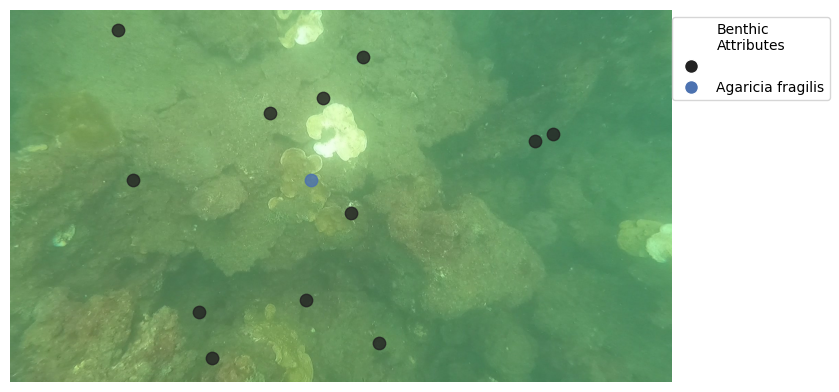

In [176]:
fig, ax = plt.subplots(figsize = (8.5, 7), layout = "tight")
plt.imshow(image)
for i, annotation in annotations.iterrows():
    plt.scatter(annotation['col'], annotation['row'], 
                color=annotation["benthic_color"],
                s=80,
                alpha=0.8)

benthic_legend_elements = get_legend_elements(annotations)

plt.legend(handles=benthic_legend_elements, bbox_to_anchor=(0.99, 1), 
          loc='upper left', title='Benthic\nAttributes')
plt.axis("off")
plt.show()

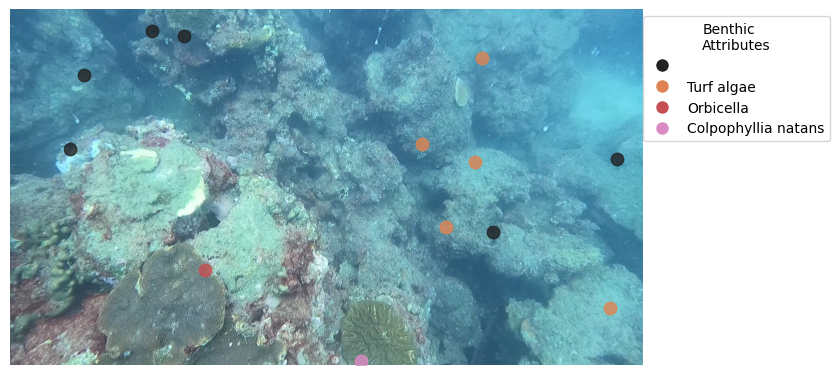

In [ ]:
image, mask, annotations = dataset[10]
fig, ax = plt.subplots(figsize = (8.5, 7), layout = "tight")
plt.imshow(image)
for i, annotation in annotations.iterrows():
    plt.scatter(annotation['col'], annotation['row'], 
                color=annotation["benthic_color"],
                s=80,
                alpha=0.8)

benthic_legend_elements = get_legend_elements(annotations)

plt.legend(handles=benthic_legend_elements, bbox_to_anchor=(0.99, 1), 
          loc='upper left', title='Benthic\nAttributes')
plt.axis("off")
plt.show()

In [130]:
response = requests.get("https://api.datamermaid.org/v1/benthicattributes/")
data = response.json()
benthic_attributes = data['results']

# Keep fetching next pages while there is a 'next' URL
while data['next']:
    response = requests.get(data['next'])
    data = response.json()
    benthic_attributes.extend(data['results'])

In [136]:
from anytree import Node, RenderTree

# Create dictionary to store nodes by ID
nodes = {}

# First pass: Create all nodes
for attr in benthic_attributes:
    node_id = attr['id']
    name = attr.get('name', 'Unknown')
    nodes[node_id] = Node(name)

# Second pass: Create parent-child relationships
for attr in benthic_attributes:
    node_id = attr['id']
    parent_id = attr.get('parent')
    if parent_id and parent_id in nodes:
        nodes[node_id].parent = nodes[parent_id]


In [137]:
# Find root nodes (nodes without parents)
root_nodes = [node for node in nodes.values() if node.parent is None]

# Print the tree structure
for root in root_nodes:
    for pre, _, node in RenderTree(root):
        print(f"{pre}{node.name}")

Macroalgae
├── Palisada
├── Padina
│   ├── Padina boergesenii
│   └── Padina antillarum
├── Hypoglossum
├── Acanthophora
│   └── Acanthophora spicifera
├── Tydemania
├── Coelothrix
├── Gelidiopsis
├── Cryptonemia
├── Laurencia
├── Hydroclathrus
├── Gracilaria
│   └── Gracilaria salicornia
├── Eucheuma
├── Neomeris
├── Stypopodium
├── Callithamniaceae
│   └── Spyridia
│       └── Spyridia filamentosa
├── Liagora
├── Ulva
├── Udotea
├── Gelidiella
├── Dichotomosiphonaceae
│   └── Avrainvillea
├── Amansia
├── Bryopsis
├── Penicillus
├── Turbinaria-algae
│   └── Turbinaria turbinata
├── Microdictyon
├── Ventricaria
├── Amphiroa
├── Peyssonneliaceae
│   ├── Peyssonnelia
│   └── Ramicrusta
├── Chlorophyta
├── Cladophora
├── Jania
├── Dictyotaceae
│   ├── Dictyopteris
│   └── Dictyota
├── Green algae
├── Gelidium
├── Cystoseira
├── Lessoniaceae
│   └── Ecklonia
├── Zellera
├── Wrangelia
├── Bonnemaisoniaceae
│   └── Asparagopsis
│       ├── Asparagopsis taxiformis
│       └── Asparagopsis arm

In [140]:
def tree_to_df(root_nodes):
    rows = []
    
    def traverse(node, path):
        # Get the full path from root to current node
        current_path = [ancestor.name for ancestor in node.path]
        # Pad with None if needed
        while len(current_path) < max_depth:
            current_path.append(None)
        rows.append(current_path)
        
        for child in node.children:
            traverse(child, path + [child.name])
    
    # Find maximum depth of the tree
    max_depth = max(node.depth + 1 for root in root_nodes for node in root.descendants)
    
    # Traverse each root node
    for root in root_nodes:
        traverse(root, [root.name])
    
    # Create DataFrame with appropriate column names
    columns = [f'Level_{i}' for i in range(max_depth)]
    df = pd.DataFrame(rows, columns=columns)
    
    return df

# Convert the tree to DataFrame
df_hierarchy = tree_to_df(root_nodes)

In [141]:
df_hierarchy

,Level_0,Level_1,Level_2,Level_3,Level_4,Level_5
0,Macroalgae,None,None,None,None,None
1,Macroalgae,Palisada,None,None,None,None
2,Macroalgae,Padina,None,None,None,None
3,Macroalgae,Padina,Padina boergesenii,None,None,None
4,Macroalgae,Padina,Padina antillarum,None,None,None
...,...,...,...,...,...,...
773,Crustose coralline algae,Titanoderma,None,None,None,None
774,Crustose coralline algae,Porolithon,None,None,None,None
775,Crustose coralline algae,Porolithon,Porolithon antillarum,None,None,None
776,Crustose coralline algae,Mesophyllum,None,None,None,None


In [142]:
response = requests.get("https://api.datamermaid.org/v1/classification/classifiers/")
data = response.json()
classifierv1_labels = data['results']

# Keep fetching next pages while there is a 'next' URL
while data['next']:
    response = requests.get(data['next'])
    data = response.json()
    classifierv1_labels.extend(data['results'])

In [147]:
len(classifierv1_labels[0]["benthic_attribute_growth_forms"])

55

In [155]:
benthic_labels = list(set([label["benthic_attribute_name"] for label in classifierv1_labels[0]["benthic_attribute_growth_forms"]]))

In [156]:
len(benthic_labels)

45

In [157]:
benthic_labels[0]

'Agaricia'

In [165]:
# Find rows where 'Agaricia' appears in any column
benthic_labels_level_dict = {}
for benthic_label in benthic_labels:
    for col in df_hierarchy.columns:
        level_labels = df_hierarchy[col].dropna().unique().tolist()
        if benthic_label in level_labels:
            print(f"{benthic_label} found in column {col} among unique labels.")
            if benthic_label not in benthic_labels_level_dict:
                benthic_labels_level_dict[benthic_label] = []
            benthic_labels_level_dict[benthic_label].append(col)

Agaricia found in column Level_2 among unique labels.
Pseudodiploria found in column Level_2 among unique labels.
Millepora found in column Level_2 among unique labels.
Astreopora found in column Level_2 among unique labels.
Fungiidae found in column Level_2 among unique labels.
Diploastrea found in column Level_2 among unique labels.
Sand found in column Level_0 among unique labels.
Rubble found in column Level_0 among unique labels.
Faviidae found in column Level_1 among unique labels.
Merulinidae found in column Level_1 among unique labels.
Dipsastraea found in column Level_2 among unique labels.
Pavona found in column Level_2 among unique labels.
Heliopora found in column Level_3 among unique labels.
Echinopora found in column Level_2 among unique labels.
Porites found in column Level_2 among unique labels.
Turbinaria-coral found in column Level_2 among unique labels.
Stylophora found in column Level_2 among unique labels.
Orbicella found in column Level_2 among unique labels.
Lobo

In [170]:
np.unique([val for key, val in benthic_labels_level_dict.items()], return_counts = True)

(array(['Level_0', 'Level_1', 'Level_2', 'Level_3'], dtype='<U7'),
 array([11,  5, 26,  3]))

In [ ]:
# Find rows where 'Agaricia' appears in any column
agaricia_locations = []
for col in df_hierarchy.columns:
    matches = df_hierarchy[df_hierarchy[col] == 'Agaricia'].index.tolist()
    if matches:
        agaricia_locations.append((matches, col))

print(f"'Agaricia' appears in:")
for indices, column in agaricia_locations:
    print(f"{column}: row(s) {indices}")

'Agaricia' appears in:
Level_2: row(s) [227, 228, 229, 230, 231, 232, 233, 234]


In [160]:
df_hierarchy

,Level_0,Level_1,Level_2,Level_3,Level_4,Level_5
0,Macroalgae,None,None,None,None,None
1,Macroalgae,Palisada,None,None,None,None
2,Macroalgae,Padina,None,None,None,None
3,Macroalgae,Padina,Padina boergesenii,None,None,None
4,Macroalgae,Padina,Padina antillarum,None,None,None
...,...,...,...,...,...,...
773,Crustose coralline algae,Titanoderma,None,None,None,None
774,Crustose coralline algae,Porolithon,None,None,None,None
775,Crustose coralline algae,Porolithon,Porolithon antillarum,None,None,None
776,Crustose coralline algae,Mesophyllum,None,None,None,None
